# Predictive Factors in Market Open With Volatility Screening
## Author: GSR
### Date: 2018-01-07

### Introduction

The futures market is open for about 23 hours per day every day. It trades before market open and after market closing periods. Because futures run for majority of the day, the participants in the markets overnight are able to react to events as if the market were open. However, the `ES` futures market suffers from lack of liquidity during non-regular hours (before 9:30 A.M., after 4:00 P.M. Eastern Time) due to lack of institutional investors actively trading throughout the night (maybe safer institutional bots trade during the night). Because the `ES` futures is highly correlated with the **S&P500** index (ETF ticker: `SPY`), it might be possible to discover a factor which suggests to which way the market will swing throughout the day, given no volatile events occur. It might also be possible to predict the market direction by analyzing the data in the first 10 minutes of the stock market being open.

In [6]:
from __future__ import print_function

import datetime

import alphalens
import pyfolio
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pykalman as pkm

from scipy.stats import jarque_bera, linregress
from quantopian.research.experimental import continuous_future

sns.set()

is_start_date = '2007-01-01'
is_end_date = '2014-01-01'

first_oos_start_date = '2014-01-01'
first_oos_end_date = '2016-01-01'

second_oos_start_date = '2016-01-01'
second_oos_end_date = str(datetime.datetime.now().date())

In [7]:
ES = continuous_future('ES')
ES_pricing_is = get_pricing(
    ES, 
    fields=['volume', 'open_price', 'close_price'], 
    frequency='minute',
    start_date=is_start_date,
    end_date=is_end_date
)

In [8]:
SPY_pricing_is = get_pricing(
    'SPY',
    fields=['volume', 'open_price', 'close_price'],
    frequency='minute',
    start_date=is_start_date,
    end_date=is_end_date
)

In [9]:
SPY_daily = get_pricing(
    'SPY',
    fields=['close_price'],
    frequency='daily',
    start_date=is_start_date,
    end_date=is_end_date
)

In [10]:
ES_pricing_is.index = ES_pricing_is.index.tz_convert('US/Eastern')
SPY_pricing_is.index = SPY_pricing_is.index.tz_convert('US/Eastern')

In [11]:
ES_daily_is = ES_pricing_is.resample('1B').last()
SPY_daily_is = SPY_pricing_is.resample('1B').last()

In [12]:
merged_daily_is = pd.concat([ES_daily_is['close_price'], SPY_daily_is['close_price']], axis=1).fillna(method='ffill').dropna()
merged_daily_is.columns = ['ES Futures (daily Resample)', 'SPY ETF (daily resample)']

merged_is = pd.concat([
        ES_pricing_is[['open_price', 'close_price']], 
        SPY_pricing_is[['open_price', 'close_price']]
    ], axis=1
).fillna(method='ffill').dropna()

merged_is.columns = ['ES open', 'ES close', 'SPY open', 'SPY close']

In [13]:
# Start from the second day in the data set so that we begin at midnight
merged_is = merged_is.loc[str(merged_is.index[0].date() + datetime.timedelta(days=1)):]

<hr />

We have imported and cleaned the `ES` futures and `SPY` ETF data, and have created a resampled dataframe with a daily time frequency. The daily data is included only for cases where we need to compare prices from another day (i.e. percentage change). 

We want to identify if the first ten minutes of trading have any effect on the direction the market will trend towards in an intraday period. Secondly, we will analyze if rolling means and mean reversion can determine the direction of the market as well. Finally, we'll attempt to apply a mean-reverting model to `SPY` that is derived from `ES` futures overnight prices. We anticipate that `ES` will dictate the general direction of the market for a day, or will mean revert when the stock market begins trading.

In [14]:
spy_10m = pd.DataFrame()
spy_10m_end = pd.DataFrame()

for tick in SPY_pricing_is.iterrows():
    hour = tick[0].hour
    minute = tick[0].minute
    
    # Consider using a hurst exponent to determine whether the series is mean reverting or trending
    if hour == 9 and minute in range(30,40):
        spy_10m = pd.concat([spy_10m, tick[1]], axis=1)

    if hour == 15 and minute in range(50, 60):
        spy_10m_end = pd.concat([spy_10m_end, tick[1]], axis=1)
        
spy_10m = spy_10m.T
spy_10m_end = spy_10m_end.T

In [15]:
def calculate_pct_gain(df, column):
    """
    The DataFrame passed into this object must have 9 items per day each formatted at the minute level.
    No other data can be passed unless it matches that condition.

    This function gets the cumulative sum of the percentage change at either the beginning of the trading
    day, or at the end.
    """
    pct_gains = pd.DataFrame()
    previous = 0

    for end_index in np.arange(9, len(df), step=9):
        pct_gains = pd.concat([
            pct_gains,
            pd.DataFrame(
                {'pct_gain': df[column].iloc[previous:end_index].pct_change().cumsum()[-1]}, 
                index=[df.iloc[previous].name.date()]
            )
        ])
        previous = end_index
        
    return pct_gains

In [16]:
spy_morning = calculate_pct_gain(spy_10m, 'close_price')
spy_closing = calculate_pct_gain(spy_10m_end, 'close_price')
spy_closing.columns = ['closing_pct_gain']
intraday_gain = spy_morning.join(spy_closing)

Let's see if our reformatted data is a normal distribution or not. For this, we will use a Jarque-Bera test, and have a cutoff $p$ value of $0.05$

In [17]:
# Let's check if our data is a normal distribution by applying a Jarque-Bera test
morning_jarque = jarque_bera(spy_morning)
closing_jarque = jarque_bera(spy_closing)
diff_jarque = jarque_bera(SPY_daily.pct_change())

jarque_pval = 0.05

# Check the p-values of the Jarque-Bera test. p < 0.05 indicates a non-normal distribution.
if morning_jarque[1] < jarque_pval:
    print('Morning pct_gain data is NOT a normal distribution.')

if closing_jarque[1] < jarque_pval:
    print('Closing pct_gain data is NOT a normal distribution.')
    
if diff_jarque[1] < jarque_pval:
    print('pct_diff data is NOT a normal distribution.')

Morning pct_gain data is NOT a normal distribution.
Closing pct_gain data is NOT a normal distribution.


From what it seems, all but daily returns in our data has a non-normal distribution. This could be a result of high kurtosis or skew in a general direction, most likely negative if I had to infer because of the market conditions this data has been through (2008 GFC, 2012 Flash Crash). Let's make scatter plots and historgrams of our to visualize the data we've gathered more easily.

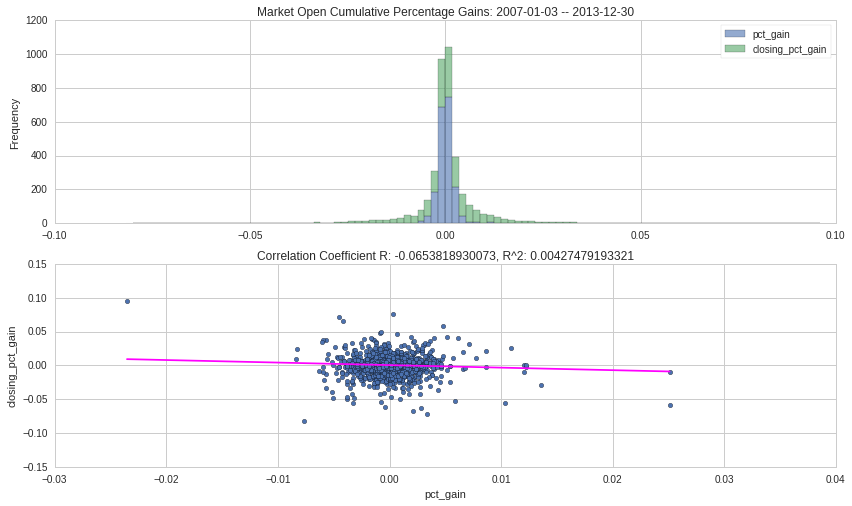

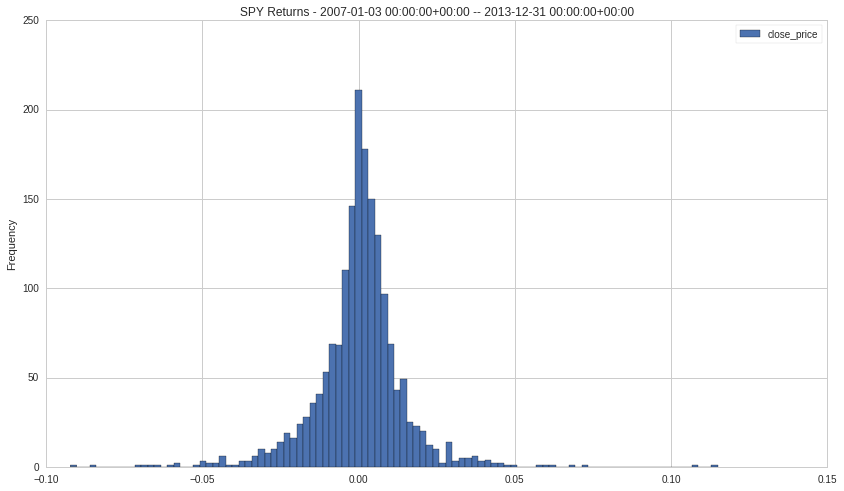

In [18]:
def plot_gains(gain_df, col_1='pct_gain', col_2='closing_pct_gain'):
    fig, (gain_hist, gain_scatter) = plt.subplots(nrows=2, ncols=1)
    gain_df.plot.hist(
        stacked=True, 
        bins=100, 
        alpha=0.6, 
        title='Market Open Cumulative Percentage Gains: %s -- %s' % (
            str(gain_df.index[0]),
            str(gain_df.index[-1])
        ),
        ax=gain_hist
    )

    gain_df.plot.scatter(
        x=col_1, 
        y=col_2, 
        ax=gain_scatter
    )

    intraday_slope, intraday_intercept, intraday_R, intraday_pval, intraday_err = linregress(
        gain_df.dropna()[col_1].values, 
        y=gain_df.dropna()[col_2].values
    )

    # Create the line of best fit and plot it on the percent gain scatterplot.
    x_gain_range = np.linspace(
        gain_df[col_1].min(), 
        gain_df[col_1].max()
    )

    gain_scatter.plot(x_gain_range, (intraday_slope * x_gain_range) + intraday_intercept, color='#ff00ff')
    gain_scatter.set_title('Correlation Coefficient R: %s, R^2: %s' % (intraday_R, intraday_R ** 2))
    
plot_gains(intraday_gain)

SPY_daily.pct_change().plot.hist(bins=100, title='SPY Returns - %s -- %s' % (
    str(SPY_daily.index[0]),
    str(SPY_daily.index[-1])
))

In [19]:
corr_trend = (intraday_gain['pct_gain'] > 0).astype(int) == (intraday_gain['closing_pct_gain'] > 0).astype(int)
intraday_count = corr_trend.apply(pd.value_counts).count()

false_count = intraday_count[0]
true_count = intraday_count[1]

total_count = false_count + true_count

print('There were %s (%s percent) instances where an upwards rise accurately predicted the outcome of the market.' % (true_count, 100 * (true_count / float(total_count))))
print('There was %s (%s percent) instances where the beginning direction did not predict the outcome of the market.' % (false_count, 100 * (false_count / float(total_count))))

There were 964 (49.3094629156 percent) instances where an upwards rise accurately predicted the outcome of the market.
There was 991 (50.6905370844 percent) instances where the beginning direction did not predict the outcome of the market.


In the case that we don't filter our data our for specific indicators that might influence the market later in the day, there appears to be no predictive power under those conditions.

There exist a few indicators that we could use that I know could filter the data better (seperate into quantiles, by volatility, RSI, Hurst exponent, etc.) Let's see if we get any different results if we split the data into quantiles based on their percentage gain.

In [20]:
intraday_cut = pd.qcut(
    intraday_gain.rolling(window=10).std().iloc[10:],
    5,
    labels=[1,2,3,4,5]
)

intraday_cut_q10 = pd.qcut(
    intraday_gain.rolling(window=10).std().iloc[10:],
    10,
    labels=[1,2,3,4,5,6,7,8,9,10]
)

In [21]:
low_vix_gain = intraday_gain.iloc[10:][(intraday_cut == 1)]
high_vix_gain = intraday_gain.iloc[10:][(intraday_cut == 5)]

### Low Volatility Histogram and Scatterplot (rolling 10 minutes)

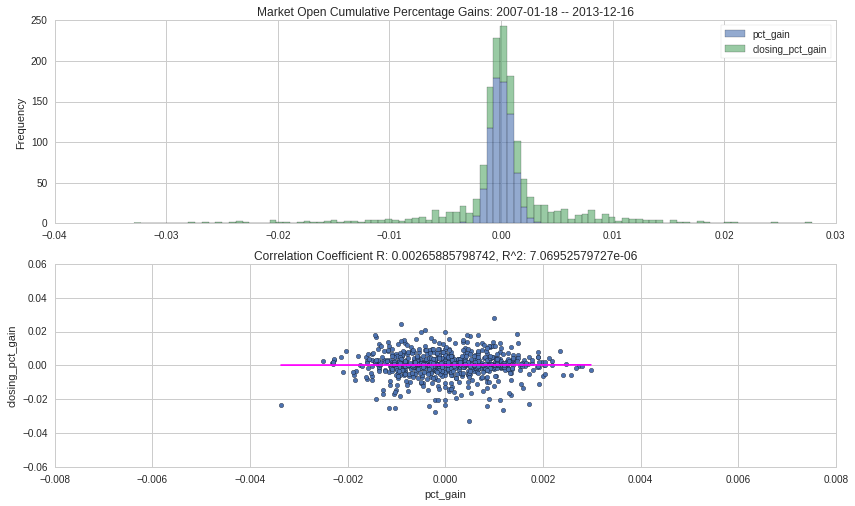

In [22]:
plot_gains(low_vix_gain)

### Low Volatility (rolling 10 minutes with bottom decile)

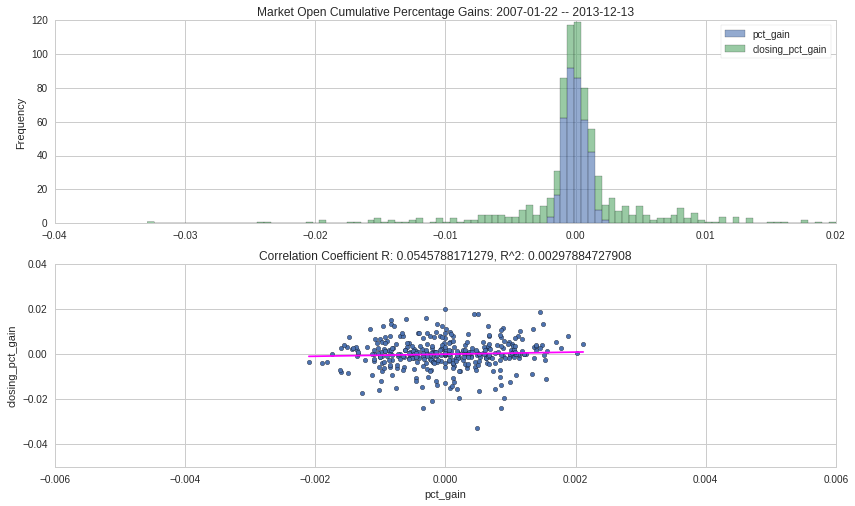

In [23]:
plot_gains(intraday_gain.iloc[10:][(intraday_cut_q10 == 1)])

### High Volatility Histogram and Scatterplot (rolling 10 minutes)

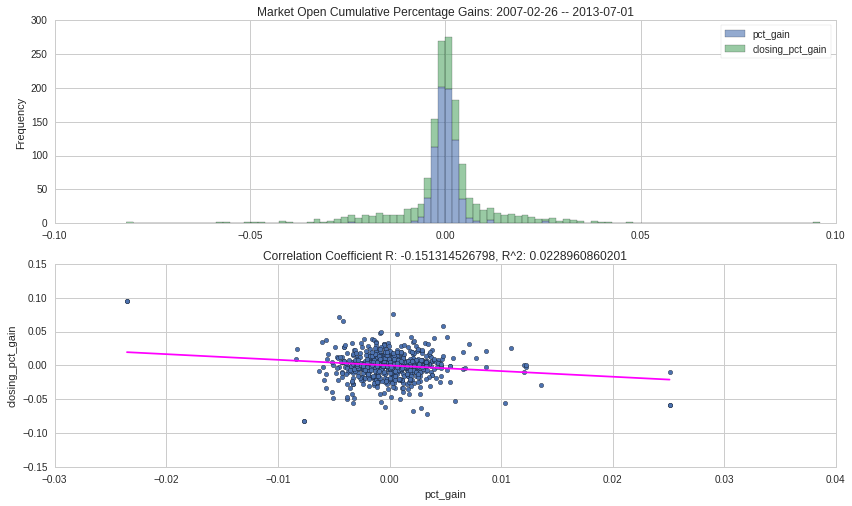

In [24]:
plot_gains(high_vix_gain)

### High Volatility (rolling 10 minutes with top decile)

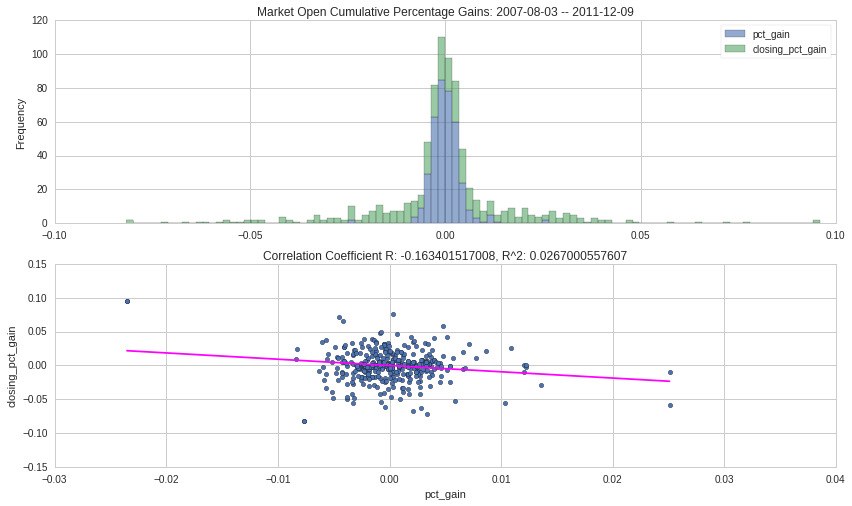

In [25]:
plot_gains(intraday_gain.iloc[10:][(intraday_cut_q10 == 10)])

Now, let's do some testing to see if S&P500 E-Mini Futures can predict the outcome of the market open. In particular, we're interested in generating excess returns during the first hour of the market being open.

In [36]:
ES_price_intraday_clean = ES_pricing_is.fillna(method='ffill').dropna()

Since the price/volume ratio is relatively low in the E-Mini markets (due to cost of contract I think?), we can plot the volume and price on a single graph to do some data visualization before we begin

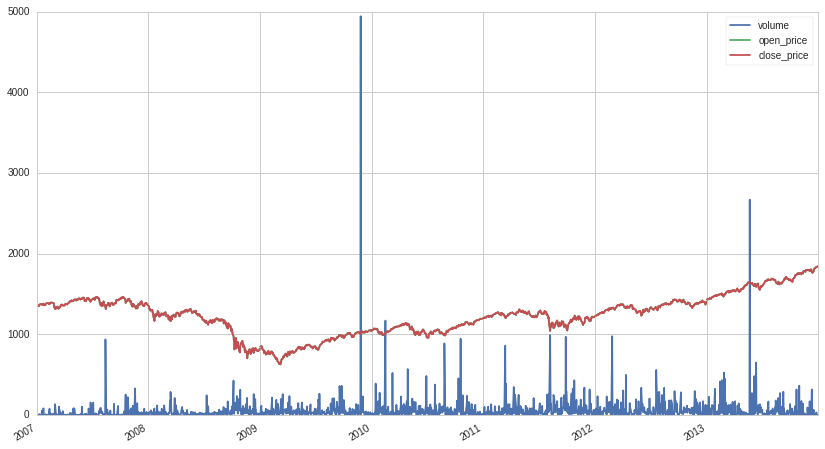

In [52]:
ES_daily_is.plot()

In [60]:
ES_nonan = ES_price_intraday_clean['close_price'].pct_change().replace(0, np.nan).dropna().iloc[1:]

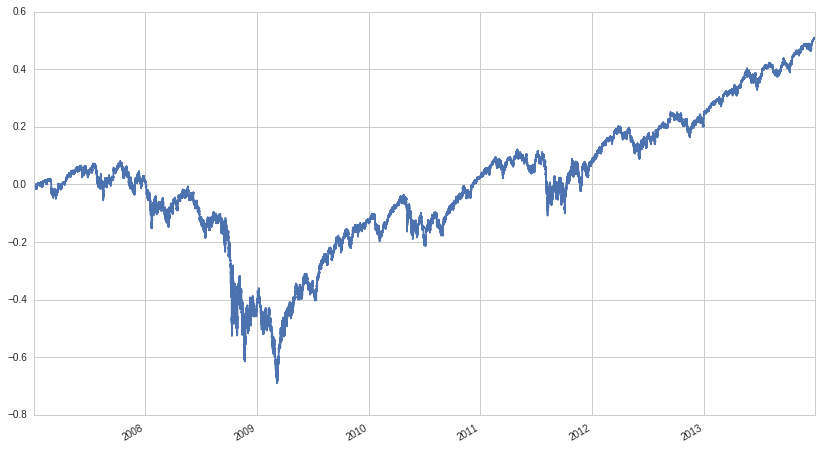

In [63]:
ES_nonan.cumsum().plot()